# Vehicle Trajectory and Motion Analysis

## Objective
To analyze vehicle trajectories obtained from multi-object tracking and compute motion-based features such as speed, direction, and path visualization.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import defaultdict

In [3]:
model=YOLO("yolov8n.pt")
video_path=r"C:\Users\vpokh\Downloads\Highway_Accident_Video_Generation.mp4"
cap=cv2.VideoCapture(video_path)
assert cap.isOpened()

In [4]:
track_history=defaultdict(list)
while cap.isOpened():
    ret,frame=cap.read()
    if not ret:
        break
    results=model.track(
        frame,
        persist=True,
        conf=0.4,
        classes=[2,3,5,7],
        verbose=False 
    )    

    if results[0].boxes.id is not None:
        boxes=results[0].boxes.xyxy.cpu().numpy()
        track_ids=results[0].boxes.id.cpu().numpy()

        for box,track_id in zip(boxes,track_ids):
            x1,y1,x2,y2=box
            cx = int((x1 + x2) / 2)
            cy = int((y1 + y2) / 2)

            track_history[int(track_id)].append((cx, cy))

cap.release()

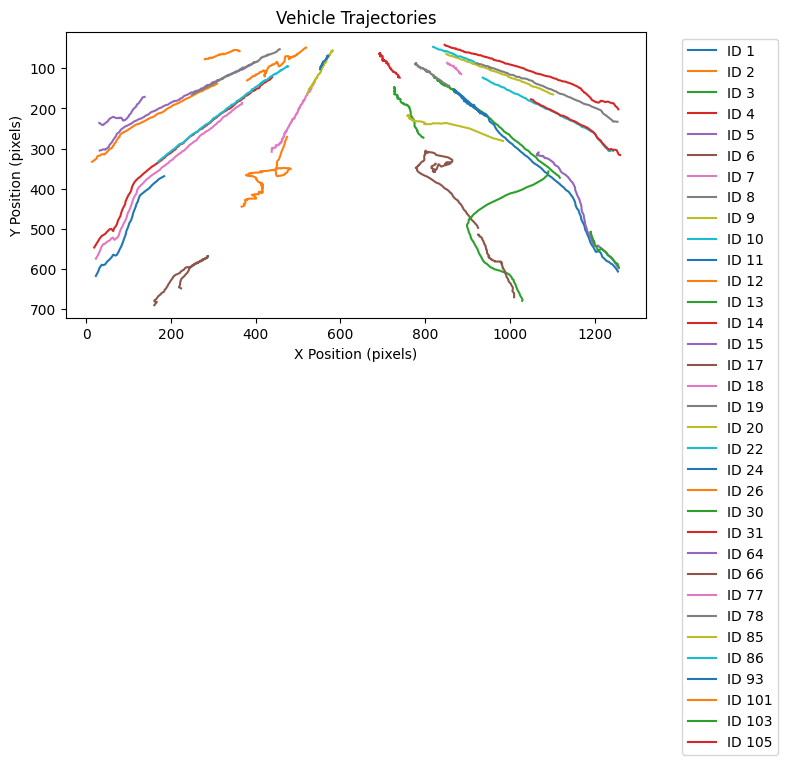

In [5]:
plt.figure(figsize=(8,6))

for track_id,points in track_history.items():
    if len(points)>20:
        xs,ys=zip(*points)
        plt.plot(xs,ys,label=f"ID {track_id}")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.title("Vehicle Trajectories")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()        

In [6]:
fps=20.37

vehicle_speeds={}
for track_id,points in track_history.items():
    if len(points)>2:
        distances=[]
        for i in range(1,len(points)):
            x1, y1 = points[i-1]
            x2, y2 = points[i]
            dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            distances.append(dist)

        avg_speed = np.mean(distances) * fps
        vehicle_speeds[track_id] = avg_speed

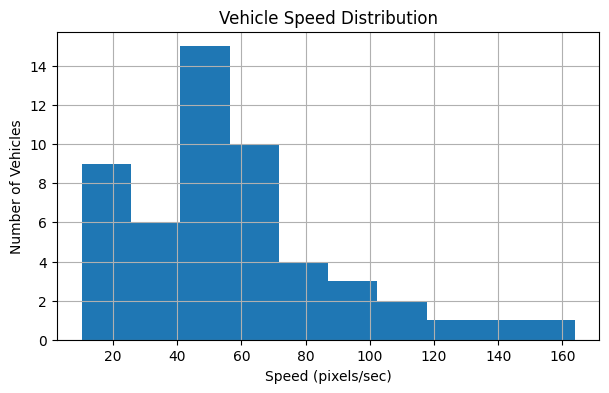

In [7]:
plt.figure(figsize=(7,4))
plt.hist(vehicle_speeds.values(), bins=10)
plt.xlabel("Speed (pixels/sec)")
plt.ylabel("Number of Vehicles")
plt.title("Vehicle Speed Distribution")
plt.grid(True)
plt.show()


In [8]:
vehicle_directions={}

for track_id,points in track_history.items():
    if len(points)>10:
       x_start, y_start = points[0]
       x_end, y_end = points[-1] 
       direction = "Left to Right" if x_end > x_start else "Right to Left"
       vehicle_directions[track_id] = direction

In [11]:
import os
os.getcwd()
os.makedirs("outputs", exist_ok=True)
import pickle

with open("outputs/trajectory_data.pkl", "wb") as f:
    pickle.dump({
        "track_history": track_history,
        "vehicle_speeds": vehicle_speeds,
        "fps": fps
    }, f)
os.listdir("outputs")

['trajectory_data.pkl']

## Observations

- Vehicle trajectories show consistent motion patterns along highway lanes.
- Average pixel-based speed varies depending on lane and traffic density.
- Direction analysis confirms dominant traffic flow direction.
- Trajectory-based features provide a strong foundation for higher-level behavioral analysis.
